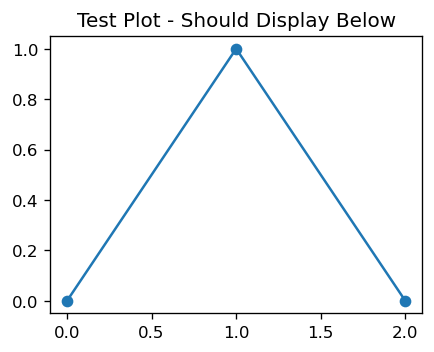

Columns in dataset:
 Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'num_r_cases',
       'r_case_number', 'r_charge_degree', 'r_days_from_arrest',
       'r_offense_date', 'r_charge_desc', 'r_jail_in', 'r_jail_out',
       'is_violent_recid', 'num_vr_cases', 'vr_case_number',
       'vr_charge_degree', 'vr_offense_date', 'vr_charge_desc',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'type_of_assessment', 'decile_score.1',
       'score_text', 'screening_date'],
      dtype='object')
Unique values in target column: [ 0 -1  1]
Accuracy: 1.0
ROC-AUC: 1.0
              precision    recall  f1-sco

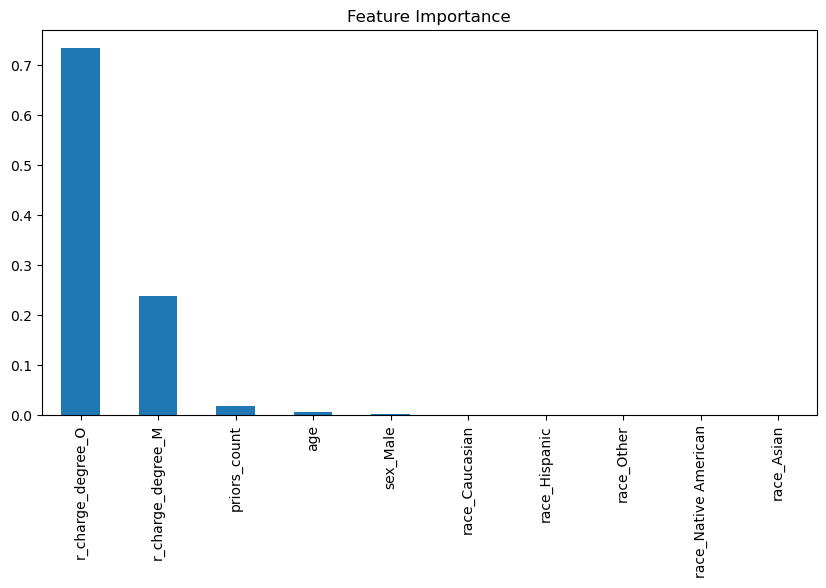

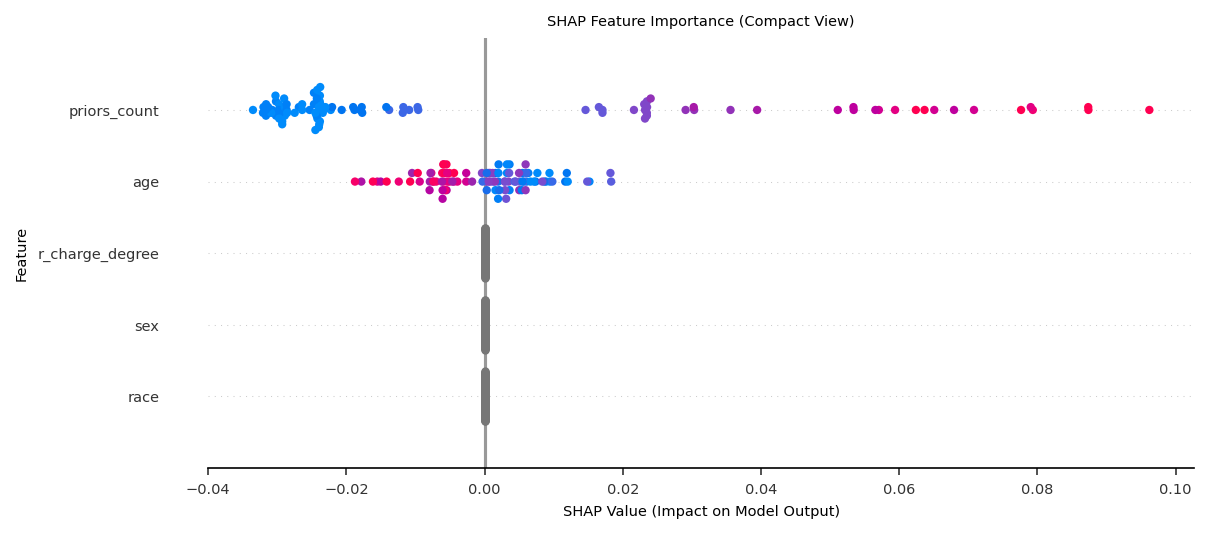

Top 20 highest-risk individuals saved to top20_highest_risk.csv


In [17]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import shap
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)

plt.figure(figsize=(4, 3), dpi=120)
plt.plot([0, 1, 2], [0, 1, 0], marker='o')
plt.title("Test Plot - Should Display Below")
plt.show()

# 2. Load Dataset
url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores.csv"
df = pd.read_csv(url)

# 3. Inspect Columns and Target
print("Columns in dataset:\n", df.columns)
# Common target column: 'two_year_recid' or 'is_recid'
print("Unique values in target column:", df['is_recid'].unique())

# 4. Clean Data & Select Features
# Drop rows with missing target
df = df.dropna(subset=['is_recid'])
# Features for model
features = ['age', 'priors_count', 'sex', 'race', 'r_charge_degree']
X = pd.get_dummies(df[features], drop_first=True)

# Ensure target is binary 0/1
y = df['is_recid'].map({0:0, 1:1})
mask = y.notna()
X = X[mask]
y = y[mask]

# 5. Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 6. Train Model
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

# 7. Evaluate Model
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:,1]  # probability for positive class

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba))
print(classification_report(y_test, y_pred))


# 8. Feature Importance
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
importances.plot(kind='bar', figsize=(10,5))
plt.title("Feature Importance")
plt.show()

# Optional: SHAP Analysis for explainability

# -------------------------------
# 2️⃣ Ensure X_test is a DataFrame
# -------------------------------
feature_names = ['age', 'priors_count', 'sex', 'race', 'r_charge_degree']
X_test = pd.DataFrame(X_test, columns=feature_names)



###############################################################################################################################

# Subsample 200 rows for safe SHAP plotting
X_train_numeric = X_train.astype(float)
X_test_numeric = X_test.astype(float)


X_small = X_test.sample(n=100, random_state=42).astype(float)
X_train_small = X_train.sample(n=100, random_state=42).astype(float)

# Black-box function for positive class
def predict_proba_fn(X):
    return model.predict_proba(X)[:, 1]

# KernelExplainer
explainer = shap.Explainer(model, X_small)
####################################################################################
#################################################################################
##################################################################################
# Compute SHAP values
shap_values = explainer(X_small)
if hasattr(shap_values, "values") and shap_values.values.ndim == 3:
    shap_values_plot = shap_values.values[:, :, 1]
else:
    shap_values_plot = shap_values.values

mask_valid = ~np.all(np.isnan(shap_values_plot), axis=0)
shap_values_plot = shap_values_plot[:, mask_valid]
X_valid = X_test.iloc[:, mask_valid]    
#########################################################################################
# Plot beeswarm
plt.figure(figsize=(9,5), dpi=150)
#shap.summary_plot(shap_values.values, X_small, plot_type="dot", max_display=10, show=False)
shap.summary_plot(shap_values_plot, X_small, plot_type="dot", max_display=25, show=False,  color_bar=False)
plt.title("SHAP Feature Importance (Compact View)", fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.xlabel("SHAP Value (Impact on Model Output)", fontsize=7)
plt.ylabel("Feature", fontsize=7)
plt.tight_layout(pad=0.5)
plt.show()
###########################################################################################


# Copy original X_test
X_test_for_shap = X_test.copy()

# One-hot encode categorical variables
X_test_for_shap = pd.get_dummies(X_test_for_shap, drop_first=True)

# Add missing columns from training (set to 0)
for col in X.columns:
    if col not in X_test_for_shap.columns:
        X_test_for_shap[col] = 0

# Reorder columns to match training exactly
X_test_for_shap = X_test_for_shap[X.columns]

y_proba_dashboard = model.predict_proba(X_test_for_shap)[:, 1]

# -------------------------------
# 3️⃣ Compute SHAP values safely on just top 20 candidates
# -------------------------------
# First get top 50 candidates by probability to ensure we have enough for SHAP
results_dashboard = pd.DataFrame({
    'index': X_test_for_shap.index,
    'pred_proba': y_proba_dashboard
})
top_candidates = results_dashboard.sort_values('pred_proba', ascending=False).head(50)
top_candidate_indices = top_candidates['index']

# Subset for SHAP calculation
X_top_candidates = X_test_for_shap.loc[top_candidate_indices]

# SHAP Explainer on subset--just now
#explainer_dashboard = shap.Explainer(model, X_top_candidates, check_additivity=False)
#shap_values_dashboard = explainer_dashboard(X_top_candidates)

explainer = shap.Explainer(model, X_top_candidates, algorithm="auto")  # safe, no additivity check
shap_values = explainer(X_top_candidates)

# -------------------------------
# 4️⃣ Extract top 20 highest-risk individuals
# -------------------------------
top20 = top_candidates.head(20)
top20_indices = top20['index']

# -------------------------------
# 5️⃣ Prepare CSV output
# -------------------------------
# shap_values_dashboard.values shape: (n_samples, n_features, n_classes)
#shap_values_positive = shap_values_dashboard.values[:, :, 1]  # class 1 (recid = True)justnow
shap_values_positive = shap_values.values[:, :, 1]  # shape: (n_samples, n_features)

shap_values_df = pd.DataFrame(shap_values_positive, 
                              columns=X_top_candidates.columns, 
                              index=X_top_candidates.index)

output_rows = []
for idx in top20_indices:
    top_features = shap_values_df.loc[idx].abs().sort_values(ascending=False).head(3)
    pred_prob = top20.loc[top20['index'] == idx, 'pred_proba'].values[0]
    original_row = df.loc[idx]  # original dataset row
    output_rows.append({
        'index': idx,
        'name': original_row['name'] if 'name' in df.columns else f"id_{idx}",
        'dob': original_row['dob'],
        'age': original_row['age'],
        'race': original_row['race'],
        'priors_count': original_row['priors_count'],
        'c_charge_desc': original_row['c_charge_desc'],
        'pred_proba': pred_prob
    })

output_df = pd.DataFrame(output_rows)

# -------------------------------
# 6️⃣ Save to CSV
# -------------------------------
output_df.to_csv("top20_highest_risks.csv", index=False)
print("Top 20 highest-risk individuals saved to top20_highest_risk.csv")
